In [4]:
import re
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from time import time

from tqdm import tqdm # progress bar
from sklearn.model_selection import train_test_split # Dividing train test
from nltk.translate.bleu_score import corpus_bleu # BLEU Score

2024-05-31 07:42:43.843677: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 07:42:43.843776: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 07:42:43.974855: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# Change this path to the dataset downloaded from Flickr8 [5]
dataset_path = "/kaggle/input/flikr-8k-dataset"
dataset_images_path = dataset_path + "/Images/"
dataset_images_path

'/kaggle/input/flikr-8k-dataset/Images/'

In [6]:
img_height = 180
img_width = 180
validation_split = 0.2

In [7]:
# Remove the last layer of the Inception V3 model
def get_encoder():
    image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
    new_input = image_model.input
    hidden_layer = image_model.layers[-1].output

    image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
    return image_features_extract_model

In [8]:
# Preprocess the caption, splitting the string and adding <start> and <end> tokens
def get_preprocessed_caption(caption):    
    caption = re.sub(r'\s+', ' ', caption)
    caption = caption.strip()
    caption = "<start> " + caption + " <end>"
    return caption

In [9]:
images_captions_dict = {}

with open("/kaggle/input/flikr-8k-dataset-captions/" + "captions.txt", "r") as dataset_info:
    next(dataset_info) # Omit header: image, caption

    # Using a subset of 4,000 entries out of 40,000
    content = dataset_info.read()
    print(content[:40])
    print(type(content))
    content = content.split("\n")
    print(len(content))
    # Using a subset of 4,000 entries out of 40,000
    # print(len(list(dataset_info)))
    for info_raw in content[:30000]:
        # print(info_raw)
        info = info_raw.split(",")
        image_filename = info[0]
        caption = get_preprocessed_caption(info[1])

        if image_filename not in images_captions_dict.keys():
            images_captions_dict[image_filename] = [caption]
        else:
            images_captions_dict[image_filename].append(caption)

1000268201_693b08cb0e.jpg,A child in a p
<class 'str'>
40456


In [10]:
# images_captions_dict

In [11]:
def load_image(image_path):
    img = tf.io.read_file(dataset_images_path + image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (img_height, img_width))
    img = tf.keras.applications.inception_v3.preprocess_input(img) # preprocessing needed for pre-trained model
    return img, image_path

In [12]:
image_captions_dict_keys = list(images_captions_dict.keys())
image_dataset = tf.data.Dataset.from_tensor_slices(image_captions_dict_keys)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [13]:
image_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [14]:
images_dict = {}
encoder = get_encoder()
for img_tensor, path_tensor in tqdm(image_dataset):
    batch_features_tensor = encoder(img_tensor)
#     print(path_tensor)
    # Loop over batch to save each element in images_dict
    for batch_features, path in zip(batch_features_tensor, path_tensor):
#         print(path)
        decoded_path = path.numpy().decode("utf-8")
        images_dict[decoded_path] = batch_features.numpy()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


100%|██████████| 94/94 [00:42<00:00,  2.19it/s]


In [15]:
def get_images_labels(image_filenames):
    images = []
    labels = []
    
    for image_filename in image_filenames:
        image = images_dict[image_filename]
        captions = images_captions_dict[image_filename]

        # Add one instance per caption
        for caption in captions:
            images.append(image)
            labels.append(caption)
            
    return images, labels

In [16]:
image_filenames = list(images_captions_dict.keys())
image_filenames_train, image_filenames_test = \
    train_test_split(image_filenames, test_size=validation_split, random_state=1)

X_train, y_train_raw = get_images_labels(image_filenames_train)
X_test, y_test_raw = get_images_labels(image_filenames_test)

In [17]:
top_k = 5000 # Take maximum of words out of 7600
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

# Generate vocabulary from train captions
tokenizer.fit_on_texts(y_train_raw)

# Introduce padding to make the captions of the same size for the LSTM model
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Create the tokenized vectors
y_train = tokenizer.texts_to_sequences(y_train_raw)

# Add padding to each vector to the max_length of the captions (automatically done)
y_train = tf.keras.preprocessing.sequence.pad_sequences(y_train, padding='post')

In [18]:
max_caption_length = max(len(t) for t in y_train)
print(max_caption_length)

35


In [19]:
len(X_train), len(y_train_raw)

(24000, 24000)

In [20]:
top_k = 5000 # Take maximum of words out of 7600
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

# Generate vocabulary from train captions
tokenizer.fit_on_texts(y_train_raw)

# Introduce padding to make the captions of the same size for the LSTM model
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Create the tokenized vectors
y_train = tokenizer.texts_to_sequences(y_train_raw)

# Add padding to each vector to the max_length of the captions (automatically done)
y_train = tf.keras.preprocessing.sequence.pad_sequences(y_train, padding='post')

In [35]:
y_train.shape

(24000, 35)

In [22]:
BUFFER_SIZE = len(X_train)
BATCH_SIZE = 64

In [23]:
# dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
import tensorflow as tf
import numpy as np

# Example data
# Replace these with your actual data paths
# x_train = np.random.rand(1000, 180, 180, 3)  # Simulated image data
# y_train = np.random.randint(0, 10, 1000)  # Simulated labels

# Define a generator function
def data_generator(x, y):
    for i in range(len(x)):
        yield x[i], y[i]

# Create a TensorFlow Dataset from the generator
batch_size = BATCH_SIZE

train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(X_train, y_train),
    output_signature=(
        tf.TensorSpec(shape=(4,4,2048), dtype=tf.float32),
        tf.TensorSpec(shape=(35,), dtype=tf.int32)
    )
)

# Shuffle, batch, and prefetch the dataset
train_dataset = train_dataset.shuffle(buffer_size=BUFFER_SIZE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# # Example usage: Iterate over the dataset
# for batch in train_dataset:
#     x_batch, y_batch = batch
#     print("x_batch shape:", x_batch.shape, "y_batch shape:", y_batch.shape)
dataset = train_dataset

In [24]:
print(dataset)
BUFFER_SIZE = len(X_train)
# BATCH_SIZE = 64
# dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Using prefetching: https://www.tensorflow.org/guide/data_performance#prefetching
# dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 4, 4, 2048), dtype=tf.float32, name=None), TensorSpec(shape=(None, 35), dtype=tf.int32, name=None))>


In [25]:
class CNN_Encoder(tf.keras.Model):
    
    def __init__(self , embedding_dim):
        super(CNN_Encoder,self).__init__()
        self.flat = tf.keras.layers.Flatten()
        self.fc = tf.keras.layers.Dense(embedding_dim)
        
    def call(self, x):
        x = self.flat(x)
        x = self.fc(x)
        return x

In [26]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self , embedding_dim , units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units  =units 
        
        self.embedding = tf.keras.layers.Embedding(vocab_size,embedding_dim)
        self.lstm = tf.keras.layers.LSTM(self.units, return_sequences=True, return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
    def call(self, captions, features, omit_features = False, initial_state = None, verbose = False):
        if verbose:
            print("Before embedding")
            print(captions.shape)

        embed = self.embedding(captions) #(batch_size, 1, embedding_dim)

        if verbose:
            print("Embed")
            print(embed.shape)

        features = tf.expand_dims(features, 1)
        
        if verbose:
            print("Features")
            print(features.shape)
        
        # Concatenating the image and caption embeddings before providing them to LSTM
        # shape == (batch_size, 1, embedding_dim + hidden_size)
        lstm_input = tf.concat([features, embed], axis=-2) if (omit_features == False) else embed
#         print(lstm_input)
        if verbose:
            print("LSTM input")
            print(lstm_input.shape)

        # Passing the concatenated vector to the LSTM
        output, memory_state, carry_state = self.lstm(lstm_input, initial_state=initial_state)

        if verbose:
            print("LSTM output")
            print(output.shape)

        # Transform LSTM output units to vocab_size
        output = self.fc(output)

        return output, memory_state, carry_state

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [27]:
def sparse_categorical_crossentropy(y_true, y_pred):
    """
    Calculate the sparse categorical cross-entropy loss.

    Parameters:
    y_true (tf.Tensor): Tensor of true labels (integer encoded).
    y_pred (tf.Tensor): Tensor of predicted logits.

    Returns:
    tf.Tensor: Sparse categorical cross-entropy loss.
    """
#     z = tf.zeros((x.shape[0],1), dtype = tf.int32)
    # Convert y_true to one-hot encoding
    y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])

    # Apply softmax to logits to get probabilities
    y_pred_softmax = tf.nn.softmax(y_pred)

    # Clip predictions to prevent log(0) which is undefined
    y_pred_clipped = tf.clip_by_value(y_pred_softmax, 1e-10, 1.0)

    # Compute the cross-entropy loss
    cross_entropy = -tf.reduce_sum(y_true_one_hot * tf.math.log(y_pred_clipped), axis=-1)
    
    return cross_entropy
    # Return the mean loss over the batch
#     return tf.reduce_mean(cross_entropy)

In [28]:
embedding_dim = 512
units = embedding_dim = 512 # As in the paper
vocab_size = min(top_k + 1, len(tokenizer.word_index.keys()))
print(vocab_size , units)

5001 512


In [29]:
loss_object = sparse_categorical_crossentropy
optimizer = tf.keras.optimizers.Adam()
def loss_function(real, pred, verbose=False):
    loss_ = loss_object(real, pred)
#     print(loss_)
    if verbose:
        print("Loss")
        print(loss_)
    
    loss_ = tf.reduce_mean(loss_, axis = 1)
        
    if verbose:
        print("After Mean Axis 1")    
        print(loss_)

    return loss_

In [30]:
# Key Point: Any Python side-effects (appending to a list, printing with print, etc) will only happen once, when func is traced. 
# To have side-effects executed into your tf.function they need to be written as TF ops:
@tf.function
def train_step(img_tensor, target, verbose=False):    
    if verbose:
        print("Image tensor")
        print(img_tensor.shape)

        print("Target")
        print(target.shape)    

    # The input would be each set of words without the last one (<end>), to leave space for the first one that
    # would be the image embedding
    dec_input = tf.convert_to_tensor(target[:, :-1])

    # Source: https://www.tensorflow.org/api_docs/python/tf/GradientTape
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        
        if verbose:
            print("Features CNN")
            print(features)
            
        predictions, _, _ = decoder(dec_input, features, verbose=verbose)        
        
        if verbose:
            print("Predictions RNN")
            print(predictions)
        
        caption_loss = loss_function(target, predictions) # (batch_size, )

        # After tape
        total_batch_loss = tf.reduce_sum(caption_loss) # Sum (batch_size, ) => K
        mean_batch_loss = tf.reduce_mean(caption_loss) # Mean(batch_size, ) => K

    # Updated the variables
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(caption_loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return total_batch_loss, mean_batch_loss

In [36]:

encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim , units , vocab_size)
i = 0 
for img , cap in dataset:
    '''x = encoder(img)
    print("from cnn: ", x.shape)
    y = decoder(cap , x ,verbose = False)
    print(type(y))
    print(y[0].shape)
#     print(cap)
    shape = (y[0].shape[0] , 1)
    cap = tf.concat([cap , tf.zeros(shape , dtype = tf.int32)], 1)
    print("sparse loss: ")
    print(loss_function(cap , y[0]))'''
#     x = train_step(img , cap)
    print("batch no.: ",i , "  shape : " ,img.shape)
    i = i+1
    if(img.shape != (64,4,4,2048)):
        continue
#     x = train_step(img , cap)
#     print(x.shape)
    

batch no.:  0   shape :  (64, 4, 4, 2048)
batch no.:  1   shape :  (64, 4, 4, 2048)
batch no.:  2   shape :  (64, 4, 4, 2048)
batch no.:  3   shape :  (64, 4, 4, 2048)
batch no.:  4   shape :  (64, 4, 4, 2048)
batch no.:  5   shape :  (64, 4, 4, 2048)
batch no.:  6   shape :  (64, 4, 4, 2048)
batch no.:  7   shape :  (64, 4, 4, 2048)
batch no.:  8   shape :  (64, 4, 4, 2048)
batch no.:  9   shape :  (64, 4, 4, 2048)
batch no.:  10   shape :  (64, 4, 4, 2048)
batch no.:  11   shape :  (64, 4, 4, 2048)
batch no.:  12   shape :  (64, 4, 4, 2048)
batch no.:  13   shape :  (64, 4, 4, 2048)
batch no.:  14   shape :  (64, 4, 4, 2048)
batch no.:  15   shape :  (64, 4, 4, 2048)
batch no.:  16   shape :  (64, 4, 4, 2048)
batch no.:  17   shape :  (64, 4, 4, 2048)
batch no.:  18   shape :  (64, 4, 4, 2048)
batch no.:  19   shape :  (64, 4, 4, 2048)
batch no.:  20   shape :  (64, 4, 4, 2048)
batch no.:  21   shape :  (64, 4, 4, 2048)
batch no.:  22   shape :  (64, 4, 4, 2048)
batch no.:  23   shap

In [32]:
checkpoint_path = "./checkpoints-my/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [33]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [41]:
from time import time
time()

1717141619.4425

In [42]:
# import time
loss_plot = []
EPOCHS = 300
start_epoch = 0

for epoch in range(start_epoch, EPOCHS):
    real_epoch = len(loss_plot) + 1
    start = time()
    total_loss = 0
    NUM_STEPS=0
    for (batch, (img_tensor, target)) in enumerate(dataset):
        if(img_tensor.shape[0] != (64)):
            continue
        total_batch_loss, mean_batch_loss = train_step(img_tensor, target, verbose=False)
        total_loss += total_batch_loss
        NUM_STEPS+=1
        if batch % 100 == 0:
            print ('Epoch {} Batch {} Batch Loss {:.4f}'.format(real_epoch, batch, mean_batch_loss.numpy()))
    
    print ('Total Loss {:.6f}'.format(total_loss))
    epoch_loss = total_loss / NUM_STEPS
    
    # storing the epoch end loss value to plot later
    loss_plot.append(epoch_loss)

#     if epoch % 5 == 0:
#         ckpt_manager.save()

    print ('Epoch {} Epoch Loss {:.6f}'.format(real_epoch, epoch_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time() - start))

Epoch 1 Batch 0 Batch Loss 8.5216
Epoch 1 Batch 100 Batch Loss 1.6800
Epoch 1 Batch 200 Batch Loss 1.4605
Epoch 1 Batch 300 Batch Loss 1.2471
Total Loss 38052.593750
Epoch 1 Epoch Loss 101.473587
Time taken for 1 epoch 30.90497398376465 sec

Epoch 2 Batch 0 Batch Loss 1.0624
Epoch 2 Batch 100 Batch Loss 1.3069
Epoch 2 Batch 200 Batch Loss 1.2738
Epoch 2 Batch 300 Batch Loss 1.1242
Total Loss 28675.882812
Epoch 2 Epoch Loss 76.469017
Time taken for 1 epoch 24.81392788887024 sec

Epoch 3 Batch 0 Batch Loss 1.0736
Epoch 3 Batch 100 Batch Loss 1.1525
Epoch 3 Batch 200 Batch Loss 1.0448
Epoch 3 Batch 300 Batch Loss 1.0263
Total Loss 26280.582031
Epoch 3 Epoch Loss 70.081551
Time taken for 1 epoch 25.246295928955078 sec

Epoch 4 Batch 0 Batch Loss 1.1109
Epoch 4 Batch 100 Batch Loss 1.0355
Epoch 4 Batch 200 Batch Loss 1.1032
Epoch 4 Batch 300 Batch Loss 0.9709
Total Loss 24700.843750
Epoch 4 Epoch Loss 65.868919
Time taken for 1 epoch 25.45104694366455 sec

Epoch 5 Batch 0 Batch Loss 0.9866


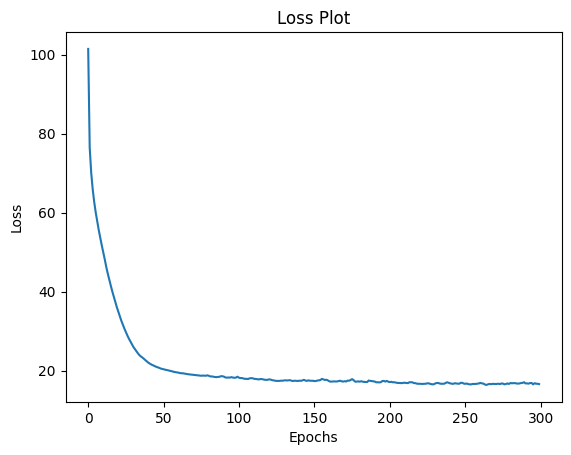

In [43]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

# Evaluation|

In [44]:
# Remove <start>, <end> and <pad> marks from the predicted sequence
def clean_caption(caption):
    return [item for item in caption if item not in ['<start>', '<end>', '<pad>']]

Real captions
<start> Three men standing on a cliff . <end>
<start> Three people are posing in front of a large rock mountain . <end>
<start> Three people are posing on the side of a mountain . <end>
<start> Three people in jackets standing at the bottom of a large rock formation . <end>
<start> Three people standing on a mountain about halfway to the top . <end>
Esimated caption
['a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'learning', 'how', 'to', 'climb', 'a', 'cliff']


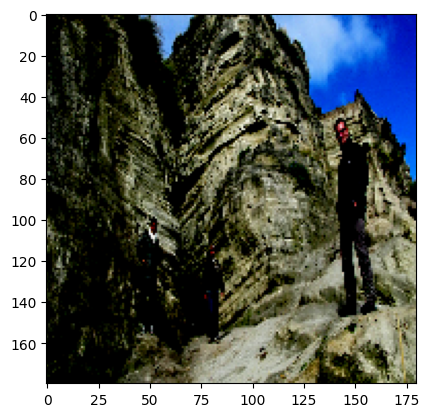

In [73]:
# Get captions from a test image

test_img_name = random.choice(image_filenames_train)
def get_caption(img):    
    # Add image to an array to simulate batch size of 1    
    features = encoder(tf.expand_dims(img, 0))
    
    caption = []
    dec_input = tf.expand_dims([], 0)
    
     # Inputs the image embedding into the trained LSTM layer and predicts the first word of the sequence.
    # The output, hidden and cell states are passed again to the LSTM to generate the next word.
    # The iteration is repeated until the caption does not reach the max length.
    state = None
    for i in range(1, max_caption_length):
        predictions, memory_state, carry_state = \
            decoder(dec_input, features, omit_features=i > 1, initial_state=state)

        # Takes maximum index of predictions
        word_index = np.argmax(predictions.numpy().flatten())

        caption.append(tokenizer.index_word[word_index])

        dec_input = tf.expand_dims([word_index], 0)       
        state = [memory_state, carry_state]
    
    # Filter caption
    return clean_caption(caption)

raw_img = load_image(test_img_name)[0]
img = images_dict[test_img_name]
captions = images_captions_dict[test_img_name]

plt.imshow(raw_img)

print("Real captions")
for caption in captions:
    print(caption)

print("Esimated caption")
estimated_caption = get_caption(img)
print(estimated_caption)